In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
import time
import unicodedata

from selenium import webdriver
from selenium.webdriver.chrome.options import Options  

In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
datetime.now()

datetime.datetime(2020, 7, 4, 17, 10, 16, 844776)

In [4]:
url = 'https://www.health.gov.au/news/health-alerts/novel-coronavirus-2019-ncov-health-alert/coronavirus-covid-19-current-situation-and-case-numbers'


driver.get(url)



In [5]:
content = driver.page_source

In [6]:
date_time_str = re.search('(\d+ \w+ 202\d)' ,str(content)).group(1)
date_time_str

'04 July 2020'

In [7]:
data_date_time = datetime.strptime(date_time_str, '%d %B %Y').strftime('%Y-%m-%d')
data_date_time

'2020-07-04'

### Dataframe

In [8]:
for i in range(40): # retry and wait till the tables are loaded
    try:
        dfs = pd.read_html(driver.page_source)
        if len(dfs)>0:
            break
    except ValueError as e:
        print(e)
    time.sleep(1)
dfs

No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found


[  Jurisdiction  Total confirmed cases  New cases in last 24 hours  Deaths
 0    Australia                   8362                         113     104
 1          ACT                    108                           0       3
 2          NSW                   3405                           5      49
 3           NT                     30                           0       0
 4          QLD                   1067                           0       6
 5           SA                    443                           0       4
 6          TAS                    228                           0      13
 7          VIC                   2469                         108      20
 8           WA                    612                           0       9,
    Unnamed: 0                           Source of Infection  Cases      %
 0         NaN                                      Overseas   4916  58.8%
 1         NaN  Locally acquired - contact of confirmed case   2394  28.6%
 2         NaN     Local

In [9]:
df = dfs[0]
df = df.iloc[:,0:2].T 
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df


Jurisdiction,Australia,ACT,NSW,NT,QLD,SA,TAS,VIC,WA
Total confirmed cases,8362,108,3405,30,1067,443,228,2469,612


In [10]:


df.insert(0, 'date', data_date_time)
df = df.rename(columns={
    'Australia':'australia',
    'ACT':'act',
    'NSW':'nsw',
    'QLD':'qld',
    'SA':'sa',
    'TAS':'tas',
    'VIC':'victoria',
    'WA':'wa',
    'NT':'nt',
})
df

Jurisdiction,date,australia,act,nsw,nt,qld,sa,tas,victoria,wa
Total confirmed cases,2020-07-04,8362,108,3405,30,1067,443,228,2469,612


In [11]:
assert int(df['australia'])>0

In [12]:
df

Jurisdiction,date,australia,act,nsw,nt,qld,sa,tas,victoria,wa
Total confirmed cases,2020-07-04,8362,108,3405,30,1067,443,228,2469,612


### Save to file

In [13]:
from pathlib import Path
csv_file = '../data/australia-cases.csv'

if Path(csv_file).exists():
    # read out the old data
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['date'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [14]:
df.sort_values(by=['date'], inplace=True)
df.to_csv(csv_file, index=False)
df

,act,australia,date,nsw,nt,qld,sa,tas,victoria,wa
0,NaN,12,2020-02-04,4,NaN,2,2,NaN,4,NaN
1,NaN,13,2020-02-05,4,NaN,3,2,NaN,4,NaN
2,NaN,14,2020-02-06,4,NaN,4,2,NaN,4,NaN
3,NaN,15,2020-02-07,4,NaN,5,2,NaN,4,NaN
4,NaN,15,2020-02-08,4,NaN,5,2,NaN,4,NaN
...,...,...,...,...,...,...,...,...,...,...
146,108,7834,2020-06-30,3189,29,1067,443,228,2159,611
147,108,7920,2020-07-01,3203,29,1067,443,228,2231,611
148,108,8001,2020-07-02,3211,30,1067,443,228,2303,611
149,108,8255,2020-07-03,3400,30,1067,443,228,2368,611


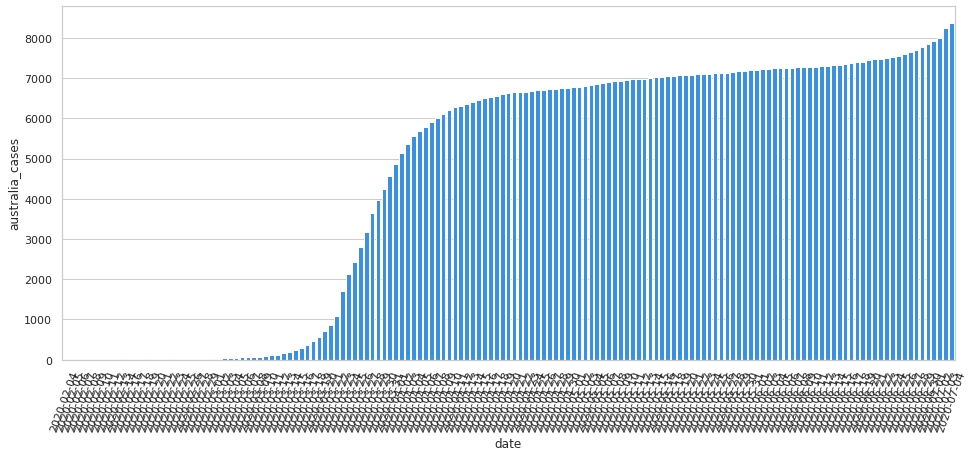

In [15]:
# plot
df['australia_cases']= df['australia'].apply(lambda x: int(x))

import seaborn as sns


sns.set(rc={'figure.figsize':(16,6.5)})
sns.set(style="whitegrid")


bar_chart = sns.barplot(x='date', y='australia_cases', color='dodgerblue', data=df)
bar_chart.tick_params(axis='x', labelrotation=70)


In [16]:
png_file = '../images/australia-cases.png'
bar_chart_fig = bar_chart.get_figure()
bar_chart_fig.savefig(png_file)
